In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [3]:
df = pd.read_csv('AirPassengers.csv')
timeseries = df[["#Passengers"]].values.astype('float32')

In [4]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

C:\Users\herbert.mariano\AppData\Local\Temp\ipykernel_28636\2443907172.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)


In [5]:
X_train

tensor([[[112.],
         [118.],
         [132.],
         [129.]],

        [[118.],
         [132.],
         [129.],
         [121.]],

        [[132.],
         [129.],
         [121.],
         [135.]],

        [[129.],
         [121.],
         [135.],
         [148.]],

        [[121.],
         [135.],
         [148.],
         [148.]],

        [[135.],
         [148.],
         [148.],
         [136.]],

        [[148.],
         [148.],
         [136.],
         [119.]],

        [[148.],
         [136.],
         [119.],
         [104.]],

        [[136.],
         [119.],
         [104.],
         [118.]],

        [[119.],
         [104.],
         [118.],
         [115.]],

        [[104.],
         [118.],
         [115.],
         [126.]],

        [[118.],
         [115.],
         [126.],
         [141.]],

        [[115.],
         [126.],
         [141.],
         [135.]],

        [[126.],
         [141.],
         [135.],
         [125.]],

        [[141.],
   

In [19]:
for x,y in zip(X_train,y_train):
    print(f"x ---- {x}")
    print(f"y ---- {y}")

x ---- tensor([[112.],
        [118.],
        [132.],
        [129.]])
y ---- tensor([[118.],
        [132.],
        [129.],
        [121.]])
x ---- tensor([[118.],
        [132.],
        [129.],
        [121.]])
y ---- tensor([[132.],
        [129.],
        [121.],
        [135.]])
x ---- tensor([[132.],
        [129.],
        [121.],
        [135.]])
y ---- tensor([[129.],
        [121.],
        [135.],
        [148.]])
x ---- tensor([[129.],
        [121.],
        [135.],
        [148.]])
y ---- tensor([[121.],
        [135.],
        [148.],
        [148.]])
x ---- tensor([[121.],
        [135.],
        [148.],
        [148.]])
y ---- tensor([[135.],
        [148.],
        [148.],
        [136.]])
x ---- tensor([[135.],
        [148.],
        [148.],
        [136.]])
y ---- tensor([[148.],
        [148.],
        [136.],
        [119.]])
x ---- tensor([[148.],
        [148.],
        [136.],
        [119.]])
y ---- tensor([[148.],
        [136.],
        [119.],
        [

In [20]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)

In [21]:
n_epochs = 3000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.8066, test RMSE 425.0600
Epoch 100: train RMSE 183.0732, test RMSE 380.2980
Epoch 200: train RMSE 148.9181, test RMSE 343.2911
Epoch 300: train RMSE 119.8719, test RMSE 309.7634
Epoch 400: train RMSE 98.0143, test RMSE 281.2803
Epoch 500: train RMSE 79.1407, test RMSE 254.4547
Epoch 600: train RMSE 64.5574, test RMSE 229.8950
Epoch 700: train RMSE 54.0862, test RMSE 208.9815
Epoch 800: train RMSE 45.6628, test RMSE 189.2377
Epoch 900: train RMSE 39.3810, test RMSE 172.1046
Epoch 1000: train RMSE 35.9450, test RMSE 162.3683
Epoch 1100: train RMSE 33.9024, test RMSE 156.5783
Epoch 1200: train RMSE 30.1367, test RMSE 142.7430
Epoch 1300: train RMSE 27.4446, test RMSE 130.9429
Epoch 1400: train RMSE 25.3864, test RMSE 120.2072
Epoch 1500: train RMSE 23.9843, test RMSE 111.7186
Epoch 1600: train RMSE 22.9309, test RMSE 104.3938
Epoch 1700: train RMSE 22.1773, test RMSE 98.2185
Epoch 1800: train RMSE 21.6261, test RMSE 93.0071
Epoch 1900: train RMSE 22.4591, test RMSE

In [22]:
X_train

tensor([[[112.],
         [118.],
         [132.],
         [129.]],

        [[118.],
         [132.],
         [129.],
         [121.]],

        [[132.],
         [129.],
         [121.],
         [135.]],

        [[129.],
         [121.],
         [135.],
         [148.]],

        [[121.],
         [135.],
         [148.],
         [148.]],

        [[135.],
         [148.],
         [148.],
         [136.]],

        [[148.],
         [148.],
         [136.],
         [119.]],

        [[148.],
         [136.],
         [119.],
         [104.]],

        [[136.],
         [119.],
         [104.],
         [118.]],

        [[119.],
         [104.],
         [118.],
         [115.]],

        [[104.],
         [118.],
         [115.],
         [126.]],

        [[118.],
         [115.],
         [126.],
         [141.]],

        [[115.],
         [126.],
         [141.],
         [135.]],

        [[126.],
         [141.],
         [135.],
         [125.]],

        [[141.],
   

In [23]:
model(X_train)

tensor([[[119.9024],
         [125.9522],
         [137.2190],
         [122.0658]],

        [[123.7544],
         [138.4611],
         [119.6767],
         [138.3686]],

        [[133.7961],
         [132.4575],
         [122.6288],
         [152.6305]],

        [[131.5065],
         [128.0901],
         [147.0949],
         [143.2515]],

        [[125.7741],
         [141.6781],
         [145.6575],
         [144.6858]],

        [[136.1655],
         [154.4960],
         [141.9491],
         [131.4124]],

        [[147.3515],
         [149.7836],
         [128.2919],
         [125.6382]],

        [[147.3515],
         [133.5362],
         [120.8103],
         [117.3607]],

        [[136.9733],
         [126.0147],
         [117.3252],
         [115.7677]],

        [[124.4203],
         [114.9189],
         [116.5676],
         [122.2929]],

        [[115.0939],
         [124.4548],
         [115.7010],
         [139.4512]],

        [[123.7544],
         [124.7466],
         [13

In [24]:
model(X_test)[:, -1, :]

tensor([[323.8013],
        [376.2373],
        [426.1642],
        [428.3828],
        [405.8071],
        [334.8653],
        [309.7167],
        [283.0558],
        [372.1825],
        [329.0438],
        [287.3505],
        [399.1894],
        [313.7552],
        [391.0327],
        [429.7159],
        [439.2200],
        [431.7875],
        [329.4594],
        [343.7546],
        [269.8180],
        [374.5886],
        [355.5146],
        [307.8030],
        [421.7102],
        [355.9991],
        [415.7864],
        [428.5854],
        [450.3839],
        [450.0073],
        [373.4988],
        [379.6685],
        [332.2206],
        [418.4444],
        [384.7546],
        [336.2654],
        [417.2354],
        [421.9365],
        [408.8217],
        [447.0770],
        [453.1415],
        [453.4662],
        [420.6993],
        [406.8354],
        [333.8868]], grad_fn=<SliceBackward0>)

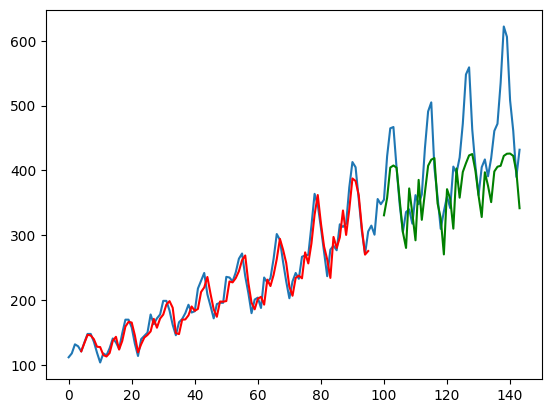

In [6]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()